In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import numpy as np
from numpy.fft import rfft2, irfft2, ifftshift
from scipy.signal import fftconvolve
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter
from numba import njit
import cv2

In [3]:
def gaussian_1d(n, center, sigma):
    x = np.arange(n, dtype=float)
    return np.exp(-0.5 * ((x - center) / sigma) ** 2)

def gaussian_weight(height, width, xc=0, yc=0, a=1, b=1):
    gx = gaussian_1d(width,  xc, a)
    gy = gaussian_1d(height, yc, b)

    weight = gy[:, None] * gx[None, :]
    weight /= weight.sum()
    return weight

# def wiener_deconvolution(weight, psf, K=0.01, dtype=np.float64):
#     """
#     Perform Wiener deconvolution on an weight function using the given PSF.
#     """
#     print("Deconvolving weight function")
#     # Convert to wanted dtype
#     weight = weight.astype(dtype, copy=False)
#     psf = psf[::-1, ::-1].astype(dtype, copy=False)
#
#     # Compute padded shape
#     pad_shape = [s1 + s2 - 1 for s1, s2 in zip(weight.shape, psf.shape)]
#
#     # Center PSF in padded array
#     psf_padded = np.zeros(pad_shape, dtype=dtype)
#     y0 = pad_shape[0] // 2 - psf.shape[0] // 2
#     x0 = pad_shape[1] // 2 - psf.shape[1] // 2
#     psf_padded[y0 : y0 + psf.shape[0], x0 : x0 + psf.shape[1]] = psf
#
#     # Compute FFTs of image and PSF
#     psf_fft = fft2(ifftshift(psf_padded))
#     weight_fft = fft2(weight, pad_shape)
#
#     # Wiener deconvolve
#     denom = (psf_fft * np.conj(psf_fft)) + K
#     result_fft = (np.conj(psf_fft) * weight_fft) / denom
#     result = np.real(ifft2(result_fft))
#
#     # Crop back to original image size
#     result = result[:weight.shape[0], :weight.shape[1]]
#     return result



def sersic(
    width,
    height,
    xc,
    yc,
    k,
    n,
    inclination=0,
    rotation=0,
    n_arms=0,
    winding=1,
    bulge_strength=1,
    Rc=30,
    direction=1,
):
    """
    Compute the Sersic galaxy centered at (xc, yc)
    """
    y, x = np.indices((width, height), dtype=float)
    x_rel = x - xc
    y_rel = y - yc

    # Transform to polar coordinates
    r = np.sqrt(x_rel**2 + y_rel**2)
    theta = np.arctan2(y_rel, x_rel) * direction

    # Calculate the bulge
    bulge = np.exp(-k * r ** (1 / n))

    # Add arms
    if n_arms > 0:
        arms = 1 + np.cos(n_arms * (theta - winding * np.log(r + 1e-6)))
    else:
        arms = 0

    # Add the arms and bulge together
    galaxy = bulge * bulge_strength + arms * np.exp(-((r / Rc) ** 2))

    # Flatten the image due to inclination
    scale_y = np.cos(inclination)
    M_incline = np.float32([[1, 0, 0], [0, scale_y, yc * (1 - scale_y)]])
    galaxy_inclined = cv2.warpAffine(
        galaxy, M_incline, (width, height), flags=cv2.INTER_CUBIC
    )

    # Rotate around (xc, yc)
    M_rot = cv2.getRotationMatrix2D((xc, yc), np.degrees(rotation), 1.0)
    galaxy_final = cv2.warpAffine(
        galaxy_inclined, M_rot, (width, height), flags=cv2.INTER_CUBIC
    )

    return galaxy_final


def moffat(
    height,
    width,
    m: float,
    a: float,
    n_spikes: int = 0,
    rotation: float = 0.0,
    spike_strength: float = 2.0,
    spike_width: float = 4.0,
    Rc: float = 10.0,
):
    """
    Calculate the PSF following moffat and add spikes if wanted
    """
    y, x = np.indices((height, width), dtype=float)
    xc, yc = width / 2, height / 2
    x_rel = x - xc
    y_rel = y - yc

    # Transform to polar coordinates
    r = np.sqrt(x_rel**2 + y_rel**2)
    theta = np.arctan2(y_rel, x_rel) + rotation

    # Calculate the center shape of the PSF
    center = (1 + (r / a) ** 2) ** (-m)

    # Calculate the spikes
    spikes = np.zeros_like(center)
    for i in range(n_spikes):
        angle = i * 2 * np.pi / n_spikes
        dist = np.abs(np.cos(theta - angle))
        spikes += np.exp(-((dist / spike_width) ** 2))

    # Add the spikes to the center
    moffat = center + spike_strength * spikes * np.exp(-((r / Rc) ** 2))
    return moffat / moffat.sum()

def find_noise_square(image, box_size=50, margin=3):
    """
    Automatically find a square region with low signal (noise-dominated).
    image: 2D array
    box_size: side of the square region (pixels)
    margin: exclude edges
    threshold: how many sigma above the median to consider as "source"
    returns: (y0, x0, y1, x1) slice indices of best noise square
    """
    img = np.asarray(image, float)
    h, w = img.shape

    # smooth absolute value to find low-variance zones
    local_mean = uniform_filter(img, size=box_size)
    local_var = uniform_filter(img**2, size=box_size) - local_mean**2
    local_std = np.sqrt(np.maximum(local_var, 0))

    # exclude borders
    local_std[:margin, :] = np.inf
    local_std[-margin:, :] = np.inf
    local_std[:, :margin] = np.inf
    local_std[:, -margin:] = np.inf

    # pick minimum std region (least structured)
    cy, cx = np.unravel_index(np.nanargmin(local_std), local_std.shape)

    # ensure square fits inside image
    half = box_size // 2
    y0 = max(0, cy - half)
    x0 = max(0, cx - half)
    y1 = min(h, y0 + box_size)
    x1 = min(w, x0 + box_size)

    return image[y0:y1, x0:x1]


def estimate_sigma(noise_image, weight, maxlag):
    local_covariance = covariance_fft2d(noise_image, maxlag)
    variance = weighted_variance_lag(weight, local_covariance, maxlag)
    return np.sqrt(variance)

def covariance_fft2d(image, maxlag):
    """
    Compute 2D covariance by FFT of background-subtracted residual.
    - image: 2D array (float)
    - maxlag: integer; returns covariance for lags -maxlag..+maxlag in both axes
    Returns: cov (2*maxlag+1, 2*maxlag+1) centered at lag (0,0)
    """
    img = image.astype(float)
    h, w = img.shape
    img -= np.mean(img)

    ac = fftconvolve(img, img[::-1, ::-1], mode="same")

    ac_norm = ac / (h * w)

    cy, cx = h//2, w//2
    window = ac_norm[cy-maxlag:cy+maxlag+1, cx-maxlag:cx+maxlag+1]
    return window


@njit
def weighted_variance_lag(s, C_local, max_lag):
    H, W = s.shape
    V = 0.0
    for dy in range(-max_lag, max_lag + 1):
        for dx in range(-max_lag, max_lag + 1):
            y0 = max(0, -dy)
            y1 = min(H, H - dy)
            x0 = max(0, -dx)
            x1 = min(W, W - dx)
            s1 = s[y0:y1, x0:x1]
            s2 = s[y0 + dy:y1 + dy, x0 + dx:x1 + dx]
            V += np.sum(s1 * s2) * C_local[dy + max_lag, dx + max_lag]
    return V

# @njit(fastmath=True)
def gaussian_1d(n, center, sigma):
    x = np.arange(n, dtype=float)
    return np.exp(-0.5 * ((x - center) / sigma) ** 2)

def gaussian_weight(height, width, xc=0, yc=0, a=1, b=1):
    gx = gaussian_1d(width,  xc, a)
    gy = gaussian_1d(height, yc, b)

    weight = gy[:, None] * gx[None, :]
    weight /= weight.sum()
    return weight

def prepare_wiener_psf(psf, image_shape, K=0.0, dtype=np.float64):
    """
    Precompute PSF FFT terms for Wiener deconvolution.
    """

    psf = psf[::-1, ::-1].astype(dtype, copy=False)

    pad_shape = (
        image_shape[0] + psf.shape[0] - 1,
        image_shape[1] + psf.shape[1] - 1,
    )

    psf_padded = np.zeros(pad_shape, dtype=dtype)
    y0 = pad_shape[0] // 2 - psf.shape[0] // 2
    x0 = pad_shape[1] // 2 - psf.shape[1] // 2
    psf_padded[y0:y0 + psf.shape[0], x0:x0 + psf.shape[1]] = psf

    H = rfft2(ifftshift(psf_padded))
    H_conj = np.conj(H)
    denom = (H * H_conj) + K

    return {
        "H_conj": H_conj,
        "denom": denom,
        "pad_shape": pad_shape,
        "image_shape": image_shape,
    }

def wiener_deconvolution_fast(weight, psf_cache, dtype=np.float64):
    """
    Fast Wiener deconvolution using cached PSF FFT data.
    """

    weight = weight.astype(dtype, copy=False)
    W = rfft2(weight, psf_cache["pad_shape"])
    F = psf_cache["H_conj"] * W / psf_cache["denom"]
    result = irfft2(F, psf_cache["pad_shape"])

    h, w = psf_cache["image_shape"]
    return result[:h, :w]

def calculate_gaap_flux(image, psf_cache, weight, centers):
    """
    Placeholder function for flux calculation.
    """
    weight_rescale = wiener_deconvolution_fast(weight, psf_cache)
    flux_map = fftconvolve(image, weight_rescale[::-1, ::-1], mode='same')

    centers = np.asarray(centers)
    ys = centers[:, 1]
    xs = centers[:, 0]

    valid = np.isfinite(xs) & np.isfinite(ys)
    measured_F = np.full(len(centers), np.nan, dtype=np.float32)
    measured_F[valid] = map_coordinates(flux_map, [ys[valid], xs[valid]], order=1)

    return measured_F, weight_rescale


def gaussian_2d(xy, amplitude, sigma, x0, y0):
    x, y = xy
    r_2 = (x - x0)**2 + (y - y0)**2
    g = amplitude * np.exp(
        -r_2/(2*sigma**2)
    )
    return g.ravel()

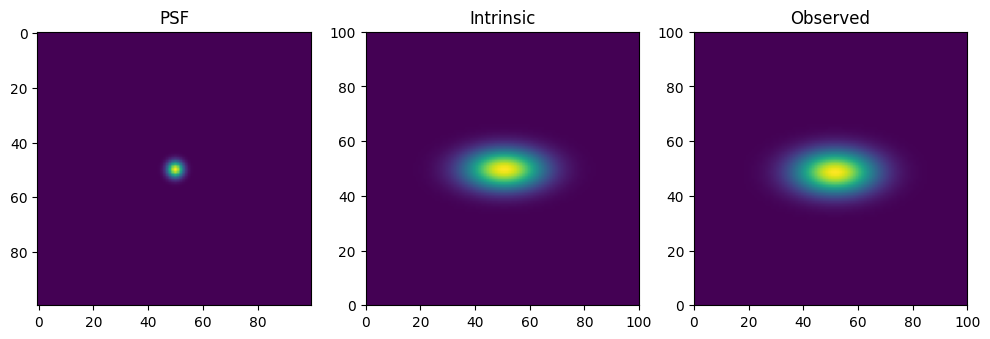

In [35]:
width = 100
height = 100
source_x_sigma = 10
source_y_sigma = 5
# Create PSF and Galaxy images
psf_sigma = 2
image_psf = gaussian_weight(height, width, height / 2, width / 2, psf_sigma, psf_sigma)
image_intrinsic = gaussian_weight(height, width, height / 2, width / 2, source_x_sigma, source_y_sigma) * 1000
# Convolve the galaxy with the PSF
image = fftconvolve(image_intrinsic, image_psf, mode="same")

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].imshow(image_psf)
axs[0].set_title("PSF")
axs[1].imshow(image_intrinsic, extent=(0, width, 0, height))
axs[1].set_title("Intrinsic")
axs[2].imshow(image, extent=(0, width, 0, height))
axs[2].set_title("Observed")
plt.show()

The aperture flux measured using the intrinsic image and weight function : 1.006586
The aperture flux using the observed image and rescaled weight function : 1.006586


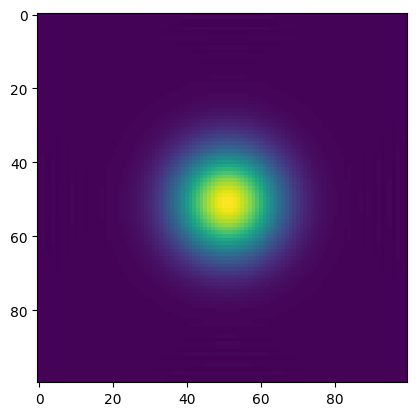

In [43]:
# Define weight function
weight = gaussian_weight(height, width, height / 2, width / 2, 10, 10)

# Calculate the aperture flux using the intrinsic image and weight function
true_F = np.sum(weight * image_intrinsic)
print(f'The aperture flux measured using the intrinsic image and weight function : {true_F:.6f}')
cache = prepare_wiener_psf(image_psf, [height, width], K=1e-10)
# Calculate the aperture flux using the observed image and rescaled weight function
measured_F, weight_new = calculate_gaap_flux(image, cache, weight, [(height / 2, width / 2)])
print(f'The aperture flux using the observed image and rescaled weight function : {measured_F[0]:.6f}')
plt.imshow(weight_new)
plt.show()

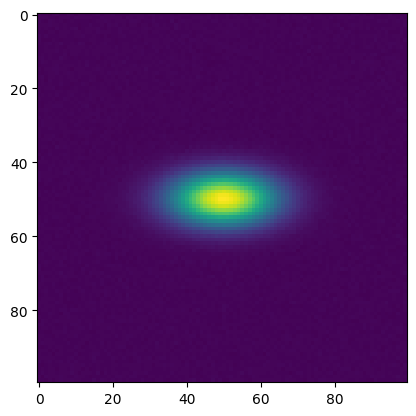

In [44]:
noise = np.random.normal(0, 1, (height, width)) * 0.01
plt.imshow(image_intrinsic + noise)
plt.show()

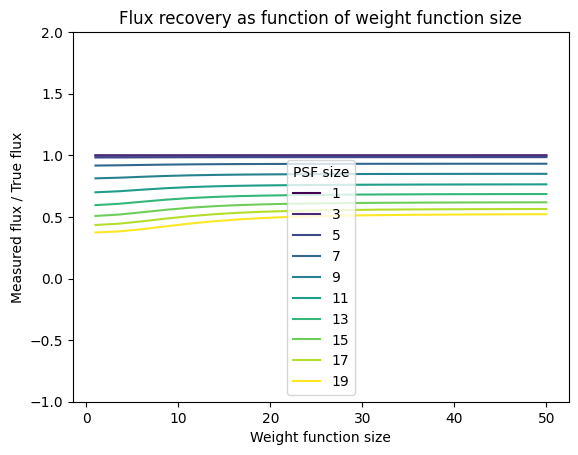

In [47]:
weight_sizes = np.linspace(1, 50, 20)
psf_sizes = np.arange(1, 20, 2)
colors = plt.cm.viridis(np.linspace(0, 1, len(psf_sizes)))
for j, psf_size in enumerate(psf_sizes):
    image_psf = gaussian_weight(height, width, height / 2, width / 2, psf_size, psf_size)
    image = fftconvolve(image_intrinsic, image_psf, mode="same")
    cache = prepare_wiener_psf(image_psf, [height, width], K=1e-3)
    true_F = np.zeros_like(weight_sizes)
    measured_F = np.zeros_like(weight_sizes)
    for i, size in enumerate(weight_sizes):
        weight = gaussian_weight(height, width, height / 2, width / 2, size)

        # Calculate the aperture flux using the intrinsic image and weight function
        true_F[i] = np.sum(weight * image_intrinsic)
        # Calculate the aperture flux using the observed image and rescaled weight function
        F, _ = calculate_gaap_flux(image, cache, weight, [(height / 2, width / 2)])
        measured_F[i] = F[0]
        # print(f'Weight size: {size:.1f}, True flux: {true_F[i]:.2f}, Measured flux: {measured_F[i]:.2f}')
    plt.plot(weight_sizes, measured_F/true_F, label=psf_size, color=colors[j])
    # plt.axvline(psf_size, linestyle='--', label=psf_size, color=colors[j])
plt.xlabel('Weight function size')
plt.ylabel('Measured flux / True flux')
plt.title('Flux recovery as function of weight function size')
# plt.axhline(1.0, color='red', linestyle='--')
plt.ylim(-1, 2)
plt.legend(title='PSF size')
plt.show()

0


/var/tmp/deklerk/ipykernel_704071/3245170621.py:21: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gaussian_2d, xdata, ydata, p0=initial_guess)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


/var/tmp/deklerk/ipykernel_704071/3245170621.py:34: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(original_sizes, np.sqrt(original_sizes**2 - psf_sigma**2), color='green', label='Expected relation')


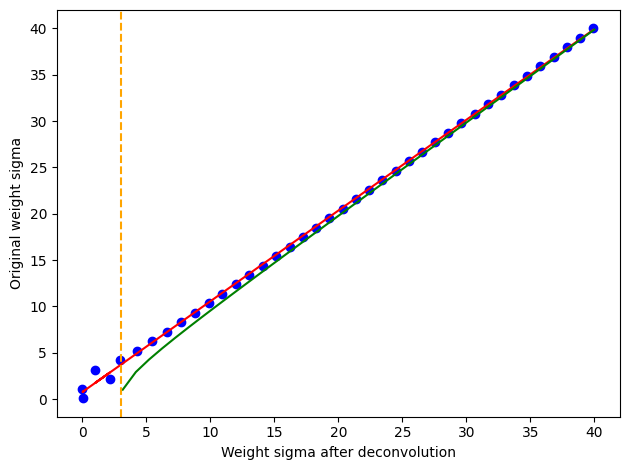

0.979635322810398 0.7561461231663172


In [134]:
from scipy.optimize import curve_fit
original_sizes = np.linspace(0.1, 40, 40)
weight_sigmas = np.full(len(original_sizes), np.nan)
for i,original_size in enumerate(original_sizes):
    print(i)
    weight = gaussian_weight(height, width, height / 2, width / 2, original_size,original_size)
    weight_rescale = wiener_deconvolution_fast(weight, cache)
    y = np.arange(weight_rescale.shape[0])
    x = np.arange(weight_rescale.shape[1])
    x, y = np.meshgrid(x, y)    # Flatten image and coordinates
    xdata = np.vstack((x.ravel(), y.ravel()))
    ydata = weight_rescale.ravel()

    amplitude_guess = np.max(weight_rescale)
    x0_guess = np.argmax(np.sum(weight_rescale, axis=0))
    y0_guess = np.argmax(np.sum(weight_rescale, axis=1))
    sigma_guess = original_size

    initial_guess = [amplitude_guess, sigma_guess, x0_guess, y0_guess]
    try:
        popt, _ = curve_fit(gaussian_2d, xdata, ydata, p0=initial_guess)

        amplitude, weight_sigma, x0, y0,  = popt
        weight_sigmas[i] = weight_sigma
    except RuntimeError:
        plt.imshow(weight_rescale)
        plt.title(f'Fit failed for original size {original_size}')
        plt.show()
        continue
A = np.column_stack((np.abs(weight_sigmas), np.ones_like(weight_sigmas)))
a, b = np.linalg.lstsq(A, original_sizes, rcond=None)[0]
plt.scatter(np.abs(weight_sigmas), original_sizes, color='blue')
plt.plot(np.abs(weight_sigmas), a * np.abs(weight_sigmas) + b, color='red')
plt.plot(original_sizes, np.sqrt(original_sizes**2 - psf_sigma**2), color='green', label='Expected relation')
plt.xlabel('Weight sigma after deconvolution')
plt.ylabel('Original weight sigma')
plt.axvline(psf_sigma, color='orange', linestyle='--', label='PSF sigma')
plt.tight_layout()
plt.show()
print(a, b)

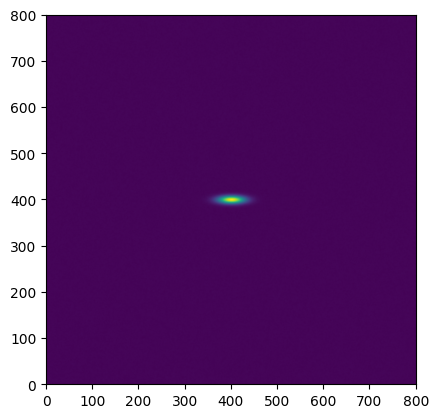

In [135]:
noise_psf = moffat(width, height, 2, 1)
noise = np.random.normal(0, .1, (height, width))
noise = fftconvolve(noise, noise_psf, mode="same")* 0.1
noisy_image = image + noise
plt.imshow(noisy_image, extent=(0, width, 0, height))
plt.show()

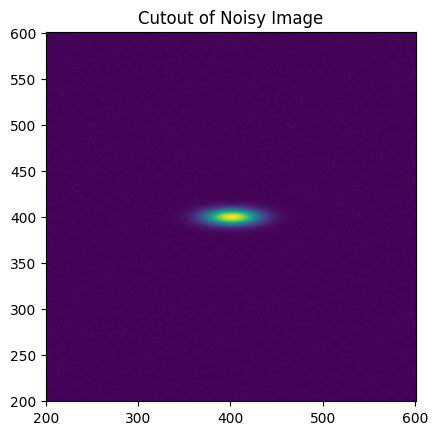

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [136]:
sizes = np.linspace(psf_sigma, 30, 20)
cutout_size = 400
snr = np.zeros((len(sizes), len(sizes)))
maxlag = 2

x0 = int(round(width / 2))
y0 = int(round(height / 2))

# bounds (clip to image)
x_min = max(0, x0 - cutout_size//2)
x_max = min(width, x0 + cutout_size//2 + 1)
y_min = max(0, y0 - cutout_size//2)
y_max = min(height, y0 + cutout_size//2 + 1)

cutout = noisy_image[y_min:y_max, x_min:x_max]
plt.imshow(cutout, extent=(x_min, x_max, y_min, y_max))
plt.title("Cutout of Noisy Image")
plt.show()
cache = prepare_wiener_psf(image_psf, [cutout_size, cutout_size], K=1e-6)
max_gaussian_size = None
max_gaussian_snr = -np.inf
for i, size_x in enumerate(sizes):
    print(i)
    for j, size_y in enumerate(sizes):
        weight = gaussian_weight(
            cutout_size, cutout_size,
            cutout_size / 2, cutout_size / 2,
            size_x, size_y
        )
        flux, weight_new = calculate_gaap_flux(
            cutout, cache, weight, [(cutout_size / 2, cutout_size / 2)]
        )
        sigma = estimate_sigma(noise[:100, :100], weight_new, maxlag)
        snr[i, j] = flux[0] / sigma
        if i == j and snr[i, j] > max_gaussian_snr:
            max_gaussian_snr = snr[i, j]
            max_gaussian_size = size_x

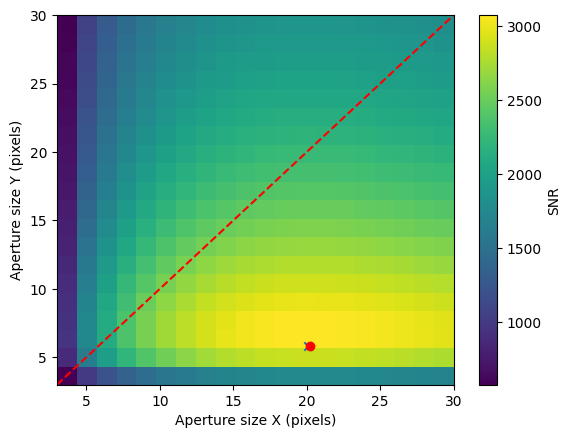

Best gaussian snr: 2566.197148459599 at size: 11.526315789473685
Best elliptical snr: 3071.347781878203 at sizes: 20.05263157894737 5.842105263157895


In [137]:
# location of maximum SNR
imax, jmax = np.unravel_index(np.argmax(snr), snr.shape)

plt.figure()
plt.imshow(
    snr.T,
    origin="lower",
    extent=[sizes[0], sizes[-1], sizes[0], sizes[-1]],
    aspect="auto"
)
plt.colorbar(label="SNR")
plt.scatter(sizes[imax], sizes[jmax], marker="x")
plt.scatter(np.sqrt(source_x_sigma**2 + psf_sigma**2), np.sqrt(source_y_sigma**2 + psf_sigma**2), marker="o", color="red", label="True source size")
plt.plot(sizes, sizes, color="red", linestyle="--", label="y=x")
plt.xlabel("Aperture size X (pixels)")
plt.ylabel("Aperture size Y (pixels)")
plt.show()
print('Best gaussian snr:', max_gaussian_snr, 'at size:', max_gaussian_size)
print('Best elliptical snr:', np.max(snr), 'at sizes:', sizes[imax], sizes[jmax])

10.526315789473685


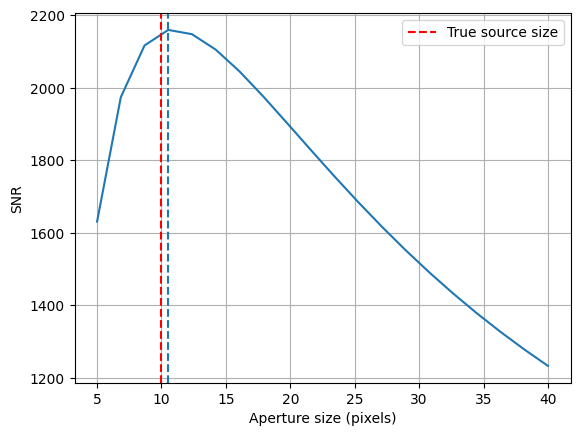

In [139]:
sizes = np.linspace(5, 40, 20)
snr = np.zeros_like(sizes) 
cache = prepare_wiener_psf(image_psf, [height, width], K=1e-6)
maxlag = 10
for i, size in enumerate(sizes):
    weight = gaussian_weight(height, width, height / 2, width / 2, size, size)
    flux, weight_new = calculate_gaap_flux(noisy_image, cache, weight, [(height / 2, width / 2)])
    sigma = estimate_sigma(noise, weight_new, maxlag)
    snr[i] = flux[0] / sigma
plt.plot(sizes, snr)
plt.axvline(sizes[np.argmax(snr)], linestyle='dashed')
plt.axvline(np.sqrt(source_x_sigma*source_y_sigma), color='red', linestyle='dashed', label='True source size')
print(sizes[np.argmax(snr)])
plt.xlabel("Aperture size (pixels)")
plt.ylabel("SNR")
plt.grid()
plt.legend()
plt.show()